Import useful programs

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ompy as om
import logging

import scipy as sp
#%matplotlib widget
from ipywidgets import widgets #interact, interactive, fixed, interact_manual

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

In [22]:
om.__full_version__;

In [23]:
# For reproducability we seed the random generator.
# Note that by default several other classes in ompy, such as all
# classes with multinest calculations have a default seed, too
np.random.seed(1382398)

In [24]:
# get smaller files for the online version
plt.rcParams["figure.dpi"] = 80

In [25]:
major_tick_length=12
minor_tick_length=5
tick_width=2
tick_labelsize=22
label_fontsize=22
title_fontsize=22
figwidth=10
figheigth=8
save_dpi = 100


def plot_3D(matrix, filename, xlabel='xlabel', ylabel='ylabel'):
    fig, ax = plt.subplots(figsize=(figwidth, figheigth))
    matrix.plot(ax=ax);
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='both', which='both', labelsize=tick_labelsize, width=tick_width)
    ax.tick_params(axis='both', which='major', length=major_tick_length)
    ax.tick_params(axis='both', which='minor', length=minor_tick_length)
    ax.set_xlabel(xlabel,fontsize=label_fontsize)
    ax.set_ylabel(ylabel,fontsize=label_fontsize)
    fig.axes[1].tick_params(labelsize=tick_labelsize)
    ax.grid(color='k', linestyle='--', linewidth=.5)
    fig.savefig(filename, dpi=save_dpi)
    
def plot_2D(matrix, filename, projection_axis, xlabel='xlabel', ylabel='ylabel', yscale='log'):
    fig, ax = plt.subplots(figsize=(figwidth, figheigth))
    matrix.plot_projection(projection_axis, kind="step", ax=ax);
    plt.yscale(yscale)
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='both', which='both', labelsize=tick_labelsize, width=tick_width)
    ax.tick_params(axis='both', which='major', length=major_tick_length)
    ax.tick_params(axis='both', which='minor', length=minor_tick_length)
    ax.set_xlabel(xlabel,fontsize=label_fontsize)
    ax.set_ylabel(ylabel,fontsize=label_fontsize)
    ax.grid(color='k', linestyle='--', linewidth=.5)
    fig.savefig(filename, dpi=save_dpi)

In [26]:
def plot_matrix(matrix, fig_name, title, scale='log', x_label='$\gamma$-ray energy $E_\gamma$', ylabel='Excitation energy $E_x$'):
    fig, ax = plt.subplots(figsize=(10, 8))
    matrix.plot(ax=ax, scale=scale);
    ax.tick_params(axis='both', labelsize=18)
    ax.set_xlabel('$\gamma$-ray energy $E_\gamma$',fontsize=18)
    ax.set_ylabel('Excitation energy $E_x$',fontsize=18)
    ax.set_title(None)
    fig.suptitle(title, fontsize=20)
    fig.axes[1].tick_params(labelsize=18)
    fig.savefig(fig_name)

In [27]:
# Import raw matrix into instance of om.Matrix()
#raw = om.Matrix(path="alfna_matrix/alfna_U233")
#raw = om.Matrix(path="alfna_matrix/alfna_right_bg_timecuts")
#raw_fiss = om.Matrix(path="alfna_matrix/alfna_fiss_right_bg_timecuts")

raw = om.Matrix(path="alfna_matrix/alfna_bigger_timecuts")
raw_fiss = om.Matrix(path="alfna_matrix/alfna_fiss_bigger_timecuts")


#Rebin matrices
raw.rebin(0,factor=12)
raw.rebin(1,factor=12)
raw_fiss.rebin(0,factor=12)
raw_fiss.rebin(1,factor=12)

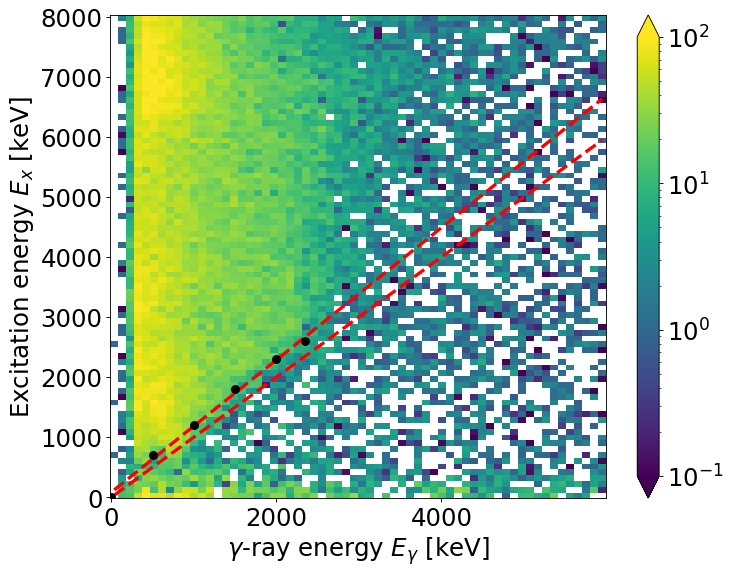

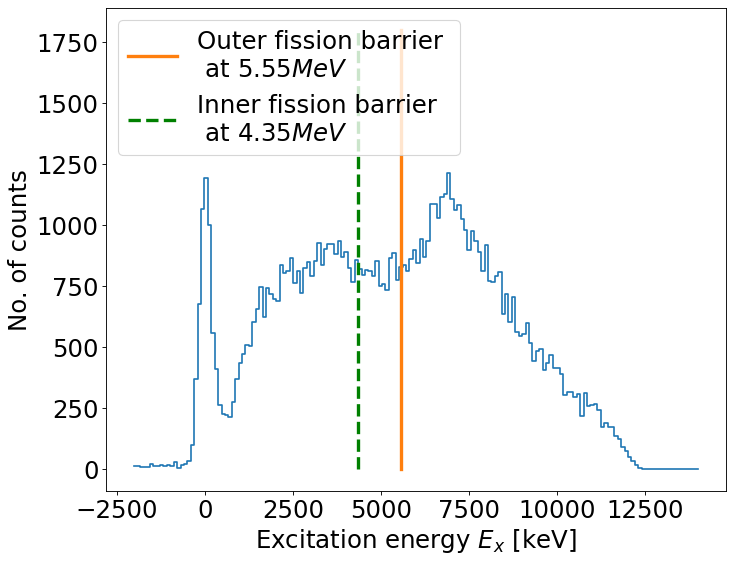

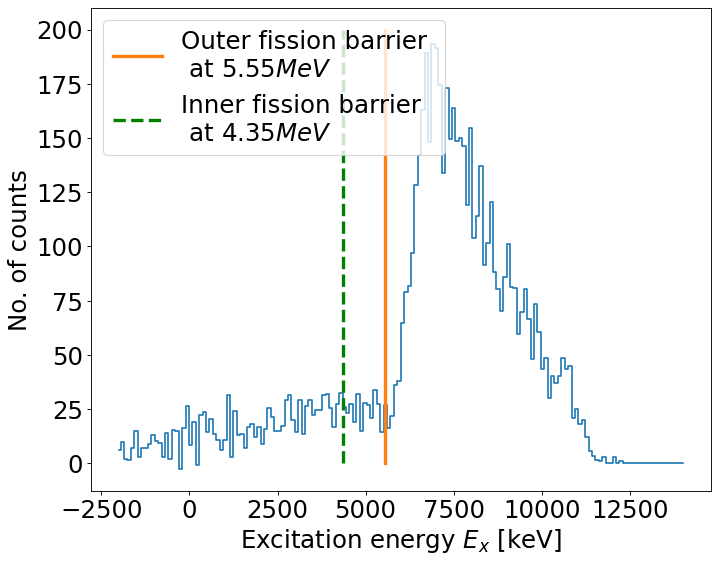

In [28]:
#plot raw matrix
raw_plot_big = raw.copy()
raw_plot_big.cut('Ex', 0, 8000)
raw_plot_big.cut('Eg', 0, 6000)

Ex = raw_plot_big.Ex
Eg = raw_plot_big.Eg

fig, ax = plt.subplots(figsize=(figwidth, figheigth))
raw_plot_big.plot(ax=ax, vmin=1e-1, vmax=1e2);
ax.tick_params(axis='both', labelsize=tick_labelsize)
ax.set_xlabel('$\gamma$-ray energy $E_\gamma$ [keV]',fontsize=label_fontsize)
ax.set_ylabel('Excitation energy $E_x$ [keV]',fontsize=label_fontsize)
ax.plot(Eg, Eg, "r--", label="E_x = E_g", linewidth=3.0);
fig.axes[1].tick_params(labelsize=tick_labelsize)

#Plot new diagonal to be used for calibration

#Linefit to calibrate Ex

#finding calibration points alog the diagonal
p0 = [0,0]
p1 = [500, 700]
p2 = [1000, 1200]
p3 = [1500, 1800]
p4 = [2000, 2300]
p5 = [2350, 2600]

#linefit
y_linefit = np.asarray([p0[1], p1[1], p2[1], p3[1], p4[1], p5[1]])
x_linefit = np.asarray([p0[0], p1[0], p2[0], p3[0], p4[0], p5[0]])
z = np.polyfit(x_linefit, y_linefit, 1)
poly = np.poly1d(z)
new_diag = Eg*poly[1] + poly[0]
ax.plot(Eg, new_diag, 'r--', linewidth=3.0);

#finding calibration points alog the diagonal
ax.plot(p0[0], p0[1], 'ko', markersize=7.0);
ax.plot(p1[0], p1[1], 'ko', markersize=7.0);
ax.plot(p2[0], p2[1], 'ko', markersize=7.0);
ax.plot(p3[0], p3[1], 'ko', markersize=7.0);
ax.plot(p4[0], p4[1], 'ko', markersize=7.0);
ax.plot(p5[0], p5[1], 'ko', markersize=7.0);



fig.savefig('plots/raw_uncalibrated', dpi=save_dpi)


#plot projection
fig, ax = plt.subplots(figsize=(figwidth, figheigth))
ax.tick_params(axis='both', labelsize=tick_labelsize)
raw.plot_projection('Ex', Emin=0, Emax=8000, kind="step", ax=ax);
ax.set_ylabel('No. of counts', fontsize=label_fontsize)
ax.set_xlabel('Excitation energy $E_x$ [keV]',fontsize=label_fontsize)
ax.plot([5550, 5550], [0, 1800], label="Outer fission barrier \n at $5.55MeV$", linewidth=3.0);
ax.plot([4350, 4350], [0, 1800], 'g--', label="Inner fission barrier \n at $4.35MeV$", linewidth=3.0);
ax.legend(fontsize=label_fontsize, loc='upper left');
fig.savefig('plots/Ex_py_uncalibrated', dpi=save_dpi)


#plot projection
fig, ax = plt.subplots(figsize=(figwidth, figheigth))
ax.tick_params(axis='both', labelsize=tick_labelsize)
raw_fiss.plot_projection('Ex', Emin=0, Emax=8000, kind="step", ax=ax);
ax.set_ylabel('No. of counts', fontsize=label_fontsize)
ax.set_xlabel('Excitation energy $E_x$ [keV]',fontsize=label_fontsize)
ax.plot([5550, 5550], [0, 200], label="Outer fission barrier \n at $5.55MeV$", linewidth=3.0);
ax.plot([4350, 4350], [0, 200], 'g--', label="Inner fission barrier \n at $4.35MeV$", linewidth=3.0);
ax.legend(fontsize=label_fontsize, loc='upper left');
fig.savefig('plots/Ex_py_fiss_uncalibrated', dpi=save_dpi)


In [29]:
#Calibrate Ex to new diagonal which is decided here
new_diag = raw.Ex*poly[1] + poly[0]
raw.Ex = 2*raw.Ex - new_diag
raw_fiss.Ex = 2*raw_fiss.Ex - new_diag

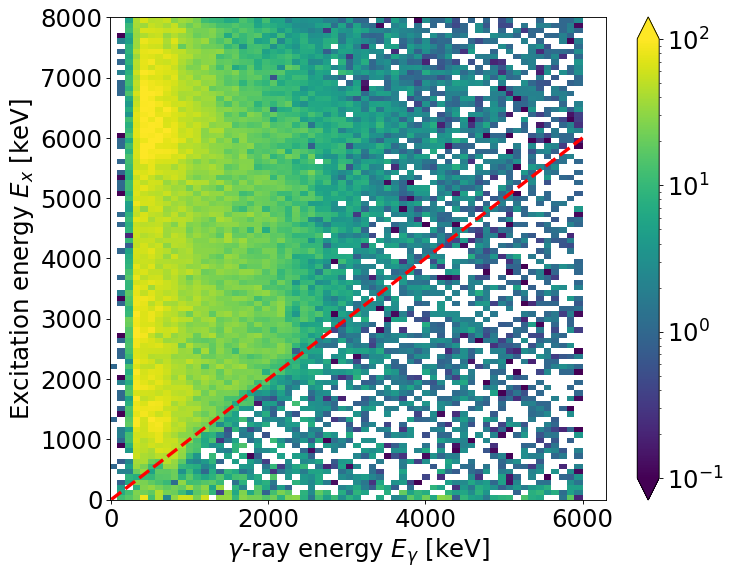

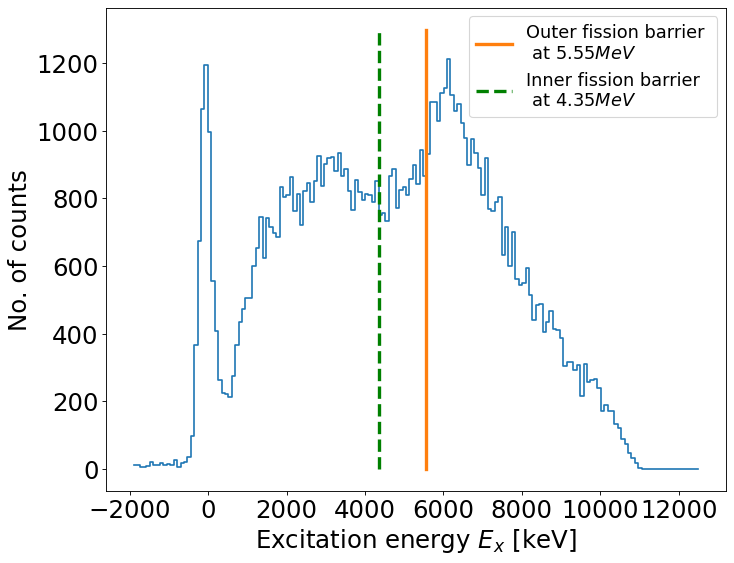

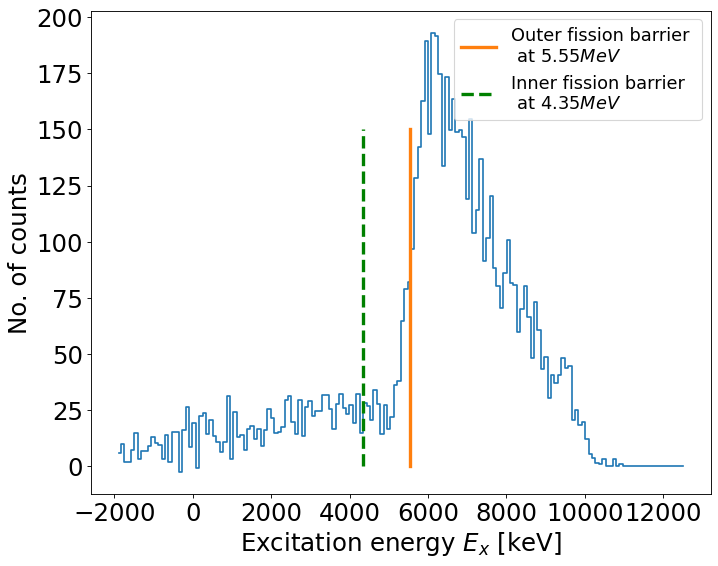

In [30]:
#plot raw matrix after calibration

raw_plot_big = raw.copy()
raw_plot_big.cut('Ex', 0, 8000)
raw_plot_big.cut('Eg', 0, 6000)


fig, ax = plt.subplots(figsize=(figwidth, figheigth))
raw_plot_big.plot(ax=ax, vmin=1e-1, vmax=1e2);
ax.tick_params(axis='both', labelsize=tick_labelsize)
ax.set_xlabel('$\gamma$-ray energy $E_\gamma$ [keV]',fontsize=label_fontsize)
ax.set_ylabel('Excitation energy $E_x$ [keV]',fontsize=label_fontsize)
x = np.linspace(0, 6000, len(raw.Ex))
ax.plot(x, x, "r--", label="E_x = E_g", linewidth=3.0);
#ax.plot(x, np.ones(len(raw.Ex))*5550, 'r--'); #fission barrier
fig.axes[1].tick_params(labelsize=tick_labelsize)
fig.savefig('plots/raw_calibrated', dpi=save_dpi)

#plot projection
fig, ax = plt.subplots(figsize=(figwidth, figheigth))
ax.tick_params(axis='both', labelsize=tick_labelsize)
raw.plot_projection('Ex', Emin=0, Emax=8000, kind="step", ax=ax);
ax.set_ylabel('No. of counts', fontsize=label_fontsize)
ax.set_xlabel('Excitation energy $E_x$ [keV]',fontsize=label_fontsize)
ax.plot([5550, 5550], [0, 1300], label="Outer fission barrier \n at $5.55MeV$", linewidth=3.0);
ax.plot([4350, 4350], [0, 1300], 'g--', label="Inner fission barrier \n at $4.35MeV$", linewidth=3.0);
ax.legend(fontsize=16, loc='upper right');
fig.savefig('plots/Ex_py_calibrated', dpi=save_dpi)


#plot projection
fig, ax = plt.subplots(figsize=(figwidth, figheigth))
ax.tick_params(axis='both', labelsize=tick_labelsize)
raw_fiss.plot_projection('Ex', Emin=0, Emax=8000, kind="step", ax=ax);
ax.set_ylabel('No. of counts', fontsize=label_fontsize)
ax.set_xlabel('Excitation energy $E_x$ [keV]',fontsize=label_fontsize)
ax.plot([5550, 5550], [0, 150], label="Outer fission barrier \n at $5.55MeV$", linewidth=3.0);
ax.plot([4350, 4350], [0, 150], 'g--', label="Inner fission barrier \n at $4.35MeV$", linewidth=3.0);
ax.legend(fontsize=16, loc='upper right');
fig.savefig('plots/Ex_py_fiss_calibrated', dpi=save_dpi)

New KeV per bin: 250.000


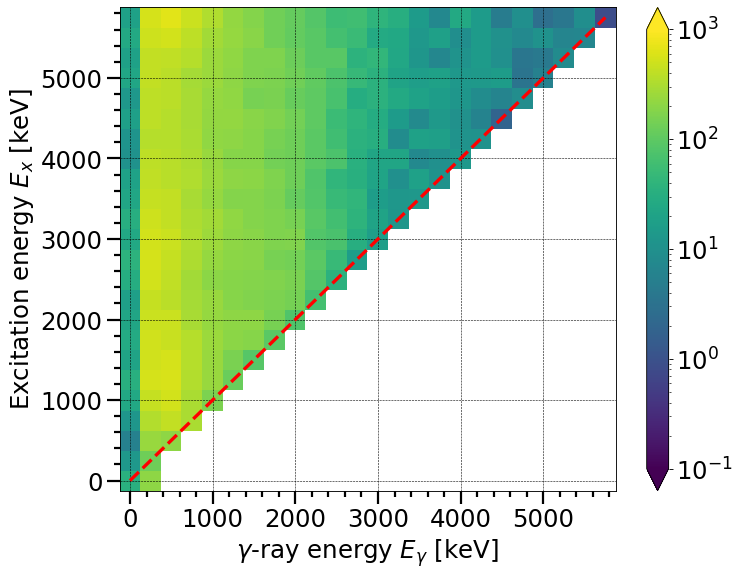

In [91]:
#Rebin raw matrix

def rebin_cut_raw(raw, kev_per_bin_wish, cut, keep=False):
    """
    Cuts raw matrix Eg and Ex at approximately cut and rebins Eg and Ex with new kev_per_bin_wish
    Cuts away diagonal too
    """
    
    raw_rebin = raw.copy()
    cut = kev_per_bin_wish*round(cut/kev_per_bin_wish)
    raw_rebin.cut('Ex', 0, cut)
    raw_rebin.cut('Eg', 0, cut)
 
    new_mids = np.linspace(kev_per_bin_wish/2, cut-(kev_per_bin_wish/2), int(cut/kev_per_bin_wish))    
    raw_rebin.rebin('Ex', mids=new_mids) #rebinning the Eg energy axis
    raw_rebin.rebin('Eg', mids=new_mids) #rebinning the Ex energy axis
    
    raw_rebin.cut_diagonal(E1=(kev_per_bin_wish, 0), E2 = (cut*2 + kev_per_bin_wish, cut*2))
    #raw_rebin.cut_diagonal(E1=(0, 0), E2 = (cut*2, cut*2))
    
    dEx = raw_rebin.Ex[1] - raw_rebin.Ex[0]
    print('New KeV per bin: %.3f'%dEx)

    #plot matrix
    fig, ax = plt.subplots(figsize=(figwidth, figheigth))
    raw_rebin.plot(ax=ax, vmin=1e-1, vmax=1e3);
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='both', which='both', labelsize=tick_labelsize, width=tick_width)
    ax.tick_params(axis='both', which='major', length=major_tick_length)
    ax.tick_params(axis='both', which='minor', length=minor_tick_length)
    ax.set_xlabel('$\gamma$-ray energy $E_\gamma$ [keV]',fontsize=label_fontsize)
    ax.set_ylabel('Excitation energy $E_x$ [keV]',fontsize=label_fontsize)
    fig.axes[1].tick_params(labelsize=tick_labelsize)
    x = np.linspace(0, cut-kev_per_bin_wish, len(raw.Ex))
    ax.plot(x, x, "r--", label="E_x = E_g", linewidth=3.0);
    ax.grid(color='k', linestyle='--', linewidth=.5)
    fig.savefig('plots/rebinned_matrix', dpi=save_dpi)
    if keep==True:
        return raw_rebin
        #raw=raw_rebin
        #raw.rebin('Ex', mids=new_mids)
        #raw.rebin('Eg', mids=new_mids)
    if keep==False:
        return raw
        
keep = True
raw = rebin_cut_raw(raw, kev_per_bin_wish=250, cut=6000, keep=keep) 


From the GettingStarted OmPy manual: "Eventhough this experiment was performed with CACTUS, we will now give an example as if the data was taken with OSCAR. This is beacause it is slightly easier to handle. For CACTUS, the response functions do not include the detector threshold; this has do be taken into account separately."

So, I need to include the detector threshold for CACTUS

2020-09-28 17:25:00,789 - ompy.response - INFO - Note: Spectra outside of 360.0 and 15000.0 are extrapolation only.
2020-09-28 17:25:00,912 - ompy.response - INFO - Note: Spectra outside of 360.0 and 15000.0 are extrapolation only.


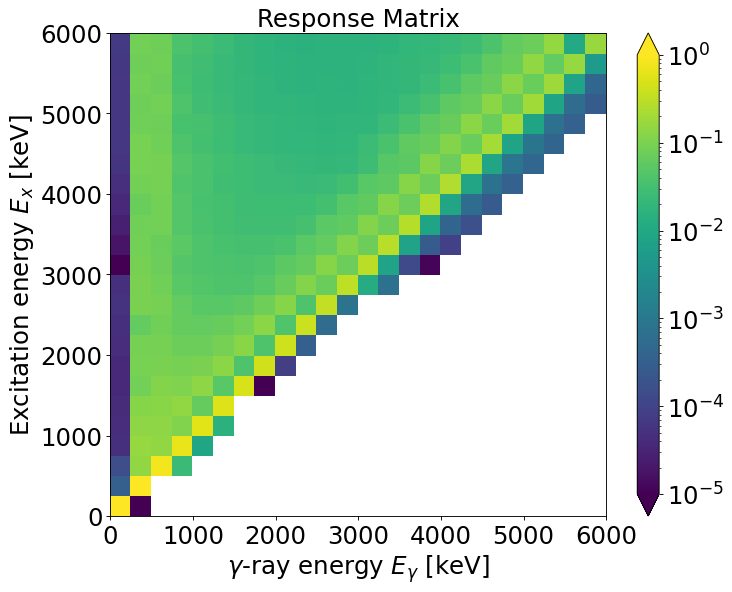

In [92]:
### GETTING RESPONSE MATRIX


logger = om.introspection.get_logger('response', 'INFO')
# Then do the same using OMpy functionality:
# You may need to adpot this to whereever you response matrixes are stored
folderpath = "../OCL_response_functions/nai2012_for_opt13"

# Energy calibration of resulting response matrix:
Eg = raw.Eg

# Experimental relative FWHM at 1.33 MeV of resulting array
fwhm_abs = 90.44 # (90/1330 = 6.8%) #CACTUS

response = om.Response(folderpath)
R_ompy_view, R_tab_view = response.interpolate(Eg, fwhm_abs=fwhm_abs, return_table=True)
# Magne recommends 1/10 of the actual resolution for unfolding purposes (see article)
R_ompy_unf, R_tab_unf = response.interpolate(Eg, fwhm_abs=fwhm_abs/10, return_table=True)

R_ompy_view.save("R_ompy_view.m")
R_ompy_unf.save("R_ompy_unf.m")
R_tab_view.to_pickle("R_tab_view.pkl")
R_tab_unf.to_pickle("R_tab_unf.pkl")

# adding response function for CACTUS
fthreshold = sp.interpolate.interp1d([30., 80., 122., 183., 244., 294., 344., 562., 779., 1000.],
                      [0.0, 0.0, 0.0, 0.06, 0.44, 0.60, 0.87, 0.99, 1.00, 1.00],
                      fill_value="extrapolate") #from mama-software ('folding.f')

def apply_detector_threshold(response, table, fthreshold):
    thres = fthreshold(response.Eg)
    response.values = response.values * thres
    # renormalize
    response.values = om.div0(response.values, response.values.sum(axis=1)[:, np.newaxis])
    table["eff_tot"] *= thres

apply_detector_threshold(R_ompy_unf, R_tab_unf, fthreshold)
apply_detector_threshold(R_ompy_view, R_tab_view, fthreshold)


fig, ax = plt.subplots(figsize=(figwidth, figheigth))
R_ompy_view.plot(ax=ax, scale="log", vmin=1e-5, vmax=1e0);
ax.tick_params(axis='both', labelsize=tick_labelsize)
ax.set_xlabel('$\gamma$-ray energy $E_\gamma$ [keV]',fontsize=label_fontsize)
ax.set_ylabel('Excitation energy $E_x$ [keV]',fontsize=label_fontsize)
ax.set_title('Response Matrix', size=title_fontsize)
fig.axes[1].tick_params(labelsize=tick_labelsize)
fig.savefig('plots/response_matrix', dpi=save_dpi)

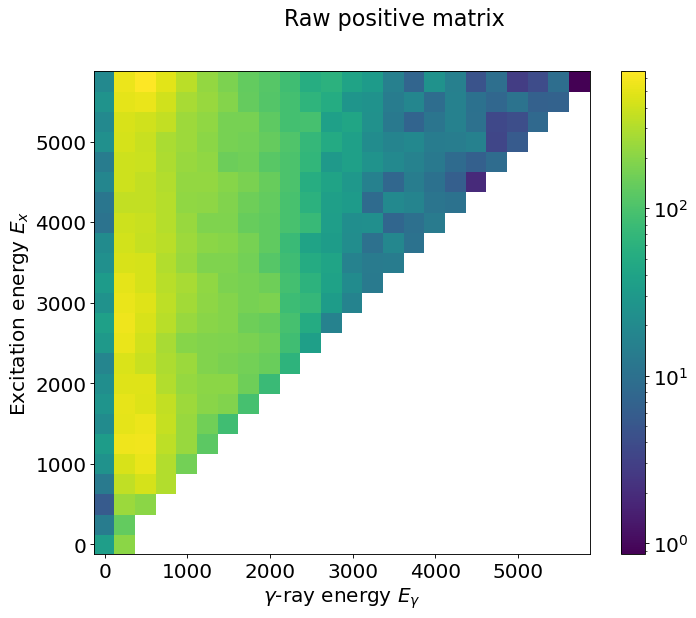

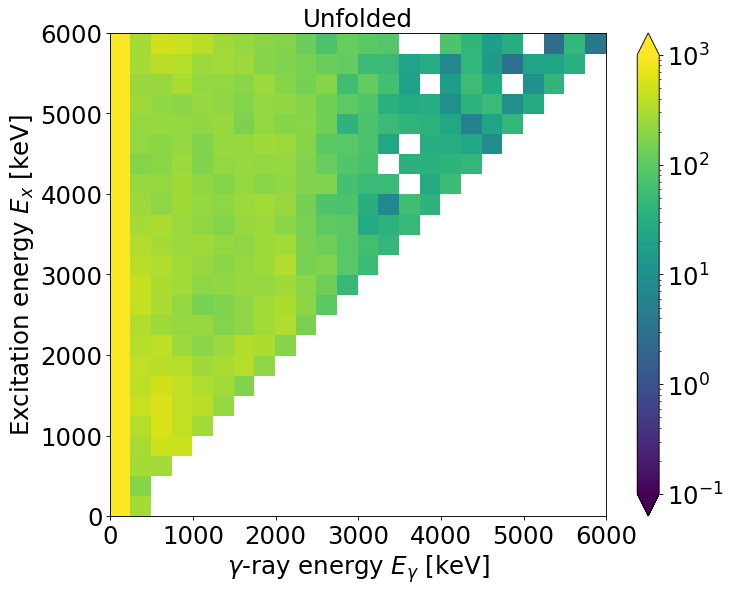

In [93]:
### UNFOLDING

# You can decide to log information and set the logging level (info/debug)
logger = om.introspection.get_logger('unfolder', 'INFO')

# We need to remove negative counts (unphysical) in the raw matrix before unfolding:
raw_positive = raw.copy()
raw_positive.fill_and_remove_negative(window_size=20)
plot_matrix(raw_positive, 'plots/raw_positive_matrix', title='Raw positive matrix')

# With compton subtraction and all tweaks
unfolder = om.Unfolder(response=R_ompy_unf)
unfolder.use_compton_subtraction = True # default
unfolder.response_tab = R_tab_unf
# Magne suggests some "tweaks" for a better unfolding performance. Default is 1 for all.
unfolder.FWHM_tweak_multiplier = {"fe": 1., "se": 1.1,
                                     "de": 1.3, "511": 0.9} #SJEKK DETTE
unfolded = unfolder(raw_positive)

fig, ax = plt.subplots(figsize=(figwidth, figheigth))
unfolded.plot(ax=ax, scale="log", vmin=1e-1, vmax=1e3);
ax.tick_params(axis='both', labelsize=tick_labelsize)
ax.set_xlabel('$\gamma$-ray energy $E_\gamma$ [keV]',fontsize=label_fontsize)
ax.set_ylabel('Excitation energy $E_x$ [keV]',fontsize=label_fontsize)
ax.set_title('Unfolded', size=title_fontsize)
fig.axes[1].tick_params(labelsize=tick_labelsize)
fig.savefig('plots/unfolded_matrix', dpi=save_dpi)



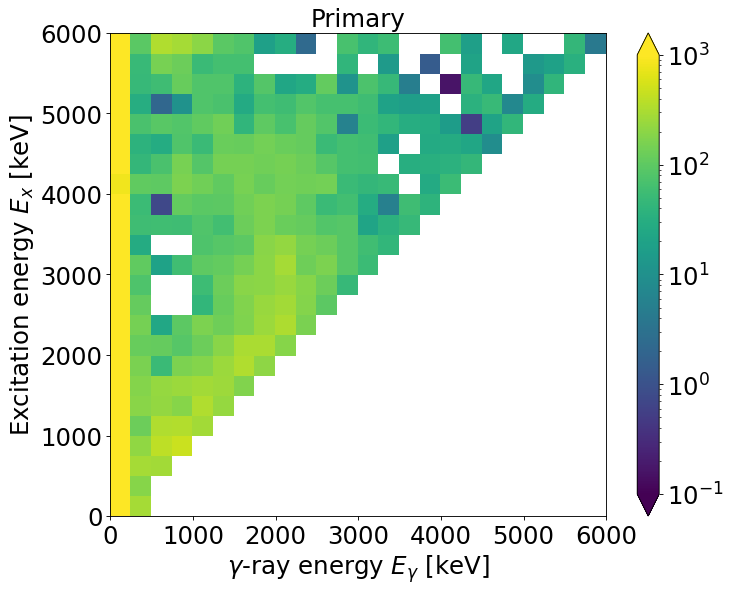

In [94]:
### Generate the first generation matrix

firstgen = om.FirstGeneration()
primary = firstgen(unfolded)

fig, ax = plt.subplots(figsize=(figwidth, figheigth))
primary.plot(ax=ax, scale="log", vmin=1e-1, vmax=1e3);
ax.tick_params(axis='both', labelsize=tick_labelsize)
ax.set_xlabel('$\gamma$-ray energy $E_\gamma$ [keV]',fontsize=label_fontsize)
ax.set_ylabel('Excitation energy $E_x$ [keV]',fontsize=label_fontsize)
ax.set_title('Primary', size=title_fontsize)
fig.axes[1].tick_params(labelsize=tick_labelsize)
fig.savefig('plots/firstgen_matrix', dpi=save_dpi)

In [95]:
### Propagating statistical uncertainties

logger = om.introspection.get_logger('ensemble', 'INFO')

# Tell the `Ensemble` class which raw spectrum, what kind of unfolder and first
# generations method to use.
# Note: This will have the same setting as above. We could for example have
# set the first generations method to use a different "valley_collection", or a
# differnt type of "multiplicity_estimation"
ensemble = om.Ensemble(raw=raw_positive)
ensemble.unfolder = unfolder
ensemble.first_generation_method = firstgen
# Generates N perturbated members; here just 10 to speed it up
# the `regenerate` flag ensures, that we don't load from disk; which might result in expected results
# if we have changed something in the input `raw` matrix.
ensemble.generate(10, regenerate=True)

2020-09-28 17:25:03,630 - ompy.ensemble - INFO - Start normalization with 3 cpus
2020-09-28 17:25:03,685 - ompy.ensemble - INFO - Generating/loading 0
2020-09-28 17:25:03,719 - ompy.ensemble - INFO - Generating/loading 1
2020-09-28 17:25:03,737 - ompy.ensemble - INFO - Generating/loading 2


2020-09-28 17:25:03,812 - ompy.ensemble - INFO - Generating/loading 3
2020-09-28 17:25:03,863 - ompy.ensemble - INFO - Generating/loading 4
2020-09-28 17:25:03,885 - ompy.ensemble - INFO - Generating/loading 5
2020-09-28 17:25:03,935 - ompy.ensemble - INFO - Generating/loading 6
2020-09-28 17:25:03,990 - ompy.ensemble - INFO - Generating/loading 7
2020-09-28 17:25:03,999 - ompy.ensemble - INFO - Generating/loading 8
2020-09-28 17:25:04,048 - ompy.ensemble - INFO - Generating/loading 9



In [96]:
#old plotting of unfolded and ensemble
#i_unfolded = 9
#matrix = ensemble.get_unfolded(i_unfolded)
#matrix.plot(title=f"Unfolded matrix #{i_unfolded}")

# Following commands plots all std. deviations
#ensemble.plot();

Extract Nuclear level density and gamma strength function

2020-09-28 17:25:04,583 - ompy.extractor - INFO - Infering calibration that calibration is in keV.
2020-09-28 17:25:04,583 - ompy.extractor - INFO - Minimizing
2020-09-28 17:25:04,721 - ompy.extractor - INFO - Optimization terminated successfully.
2020-09-28 17:25:04,721 - ompy.extractor - INFO -          Current function value: 411.611528
2020-09-28 17:25:04,722 - ompy.extractor - INFO -          Iterations: 5
2020-09-28 17:25:04,722 - ompy.extractor - INFO -          Function evaluations: 2777
2020-09-28 17:25:04,746 - ompy.extractor - INFO - Infering calibration that calibration is in keV.
2020-09-28 17:25:04,748 - ompy.extractor - INFO - Minimizing
2020-09-28 17:25:04,864 - ompy.extractor - INFO - Optimization terminated successfully.
2020-09-28 17:25:04,865 - ompy.extractor - INFO -          Current function value: 366.098593
2020-09-28 17:25:04,866 - ompy.extractor - INFO -          Iterations: 4
2020-09-28 17:25:04,866 - ompy.extractor - INFO -          Function evaluations: 221

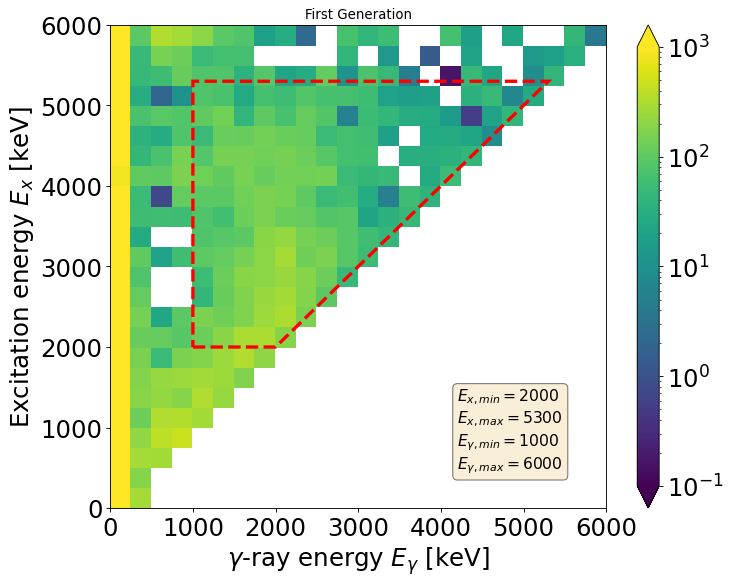

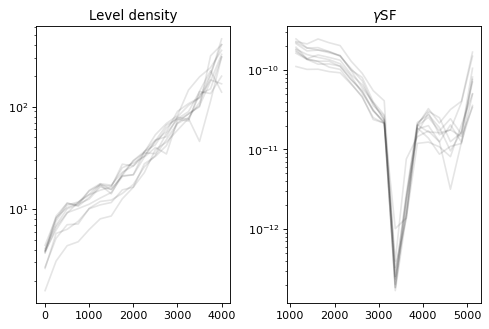

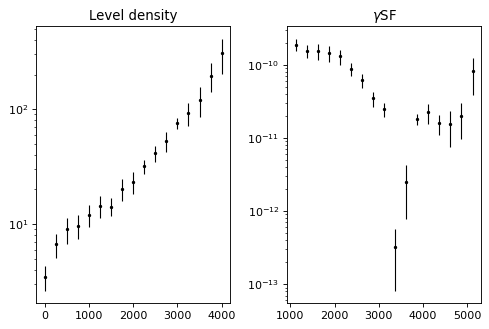

In [97]:
extlog = om.introspection.get_logger('extractor', 'INFO')
trapezoid_cut = om.Action('matrix')
# Trapezoidal cuts
Ex_min = 2000
Ex_max = 5300
Eg_min = 1000
Eg_max = 6000

#plot primary matrix with trapezoidal cuts:
fig, ax = plt.subplots(figsize=(figwidth, figheigth))
primary.plot(ax=ax, scale="log", vmin=1e-1, vmax=1e3);
ax.tick_params(axis='both', labelsize=tick_labelsize)
ax.set_xlabel('$\gamma$-ray energy $E_\gamma$ [keV]',fontsize=label_fontsize)
ax.set_ylabel('Excitation energy $E_x$ [keV]',fontsize=label_fontsize)
# Trapez
x = [Eg_min, Ex_min, Ex_max, Eg_min]
y = [Ex_min, Ex_min, Ex_max, Ex_max]
textstr = '\n'.join((
    r'$E_{x, min}=%.0f$' % (Ex_min, ),
    r'$E_{x, max}=%.0f$' % (Ex_max, ),
    r'$E_{\gamma, min}=%.0f$' % (Eg_min, ),
    r'$E_{\gamma, max}=%.0f$' % (Eg_max, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(.70, 0.25, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

ax.add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False, linewidth=3.0, color='r', linestyle='--'))
fig.axes[1].tick_params(labelsize=tick_labelsize)
fig.savefig('plots/firstgen_trapezoid', dpi=save_dpi)


#Perform trapezoidal cut
trapezoid_cut.trapezoid(Ex_min=Ex_min, Ex_max=Ex_max, Eg_min=Eg_min, Eg_max = Eg_max, inplace=True)
extractor = om.Extractor()
extractor.trapezoid = trapezoid_cut


E_rebinned = ensemble.get_firstgen(0).Ex
ensemble.rebin(E_rebinned, member="firstgen")

extractor.extract_from(ensemble, regenerate=True)

extractor.plot(scale='log', plot_mean=False);
plt.savefig('unnormed_new_falsemean')

extractor.plot(scale='log', plot_mean=True);
plt.savefig('unnormed_new_truemean')

In [98]:
# let's remove the nan-valued elements (unconstrained elements) for the further analysis
for nld in extractor.nld:
    nld.cut_nan()

for gsf in extractor.gsf:
    gsf.cut_nan()

Normalization parameters and explanation:

D0: 4.6 +/- 0.7 Average s-wave resonance spacing D0 [eV] Taken from https://www-nds.iaea.org/RIPL-3/, https://www-nds.iaea.org/cgi-bin/ripl_den_ldp.pl?Z=92&A=233

Sn: Neutron separation energy [MeV] Taken from https://www-nds.iaea.org/RIPL-3/, https://www-nds.iaea.org/cgi-bin/ripl_levels.pl?Z=92&A=233

Spincut pars. Parameters necessary for the spin cut model:
    NLDa: Level density parameter. Taken from https://journals.aps.org/prc/abstract/10.1103/PhysRevC.80.054310 (Egidy, Bucurescu 2009)
    
    Eshift: Total backshift parameter. Taken from https://journals.aps.org/prc/abstract/10.1103/PhysRevC.80.054310 (Egidy, Bucurescu 2009)
    
    sigma2_disc: spin cutoff parameter discrepancy?
    
Jtarget: 5/2+ “Target” (A-1 nucleus) ground state spin. From https://www-nds.iaea.org/cgi-bin/ripl_levels.pl?Z=92&A=233

nldnorm:
    limit_low:
    
    limit_high:
    
gsfnorm:
    Gg: Total average radiative width [meV]
    
    
printout from ompy source-code 
        """ Get the square of the spin cut for a specified model 

        if model == "const":
            pars_req = {"sigma"}
            return call_model(self.gconst, pars, pars_req)
        elif model == "EB05":
            pars_req = {"mass", "NLDa", "Eshift"}
            return call_model(self.gEB05, pars, pars_req)
        elif model == "EB09_CT":
            pars_req = {"mass"}
            return call_model(self.gEB09_CT, pars, pars_req)
        elif model == "EB09_emp":
            pars_req = {"mass", "Pa_prime"}
            return call_model(self.gEB09_emp, pars, pars_req)
        elif model == "Disc_and_EB05":
            pars_req = {"mass", "NLDa", "Eshift", "Sn", "sigma2_disc"}
            return call_model(self.gDisc_and_EB05, pars, pars_req)
            
The different spin-cutoff models to use. Which one?

In [129]:
#Normalization parameters

regenerator = True

norm_pars = om.NormalizationParameters(name='233U')
norm_pars.D0 = [4.6, 0.7]  # eV #SJEKK
norm_pars.Sn = [5.761930, 0]# MeV #SJEKK

#Which spin-cutoff model to use (uncomment to use):

norm_pars.spincutModel = 'Disc_and_EB05'  # see eg. Guttormsen et al., 2017, PRC 96, 024313
norm_pars.spincutPars = {"mass":233, "NLDa":23.23, "Eshift":-0.33, "Sn": norm_pars.Sn[0], "sigma2_disc":[1.5, 3.6]}

#norm_pars.spincutModel = 'EB09_CT'
#norm_pars.spincutPars = {"mass":233}

#norm_pars.spincutModel = 'EB05'
#norm_pars.spincutPars = {"mass":233, "NLDa":23.23, "Eshift":-0.33}


norm_pars.Jtarget = 5/2 # A-1 nucleus

# NLD normalizer parameters

normlog = om.introspection.get_logger('normalizer_nld', 'INFO')
nldnorm = om.NormalizerNLD(nld=extractor.nld[0], discrete='discrete_levels_U233.txt', regenerate=regenerator)
nldnorm.limit_low = [0.2, 0.6]
nldnorm.limit_high=[1.3, 3.3]
nldnorm.norm_pars = norm_pars

# gSF normalizer parameters

normlog = om.introspection.get_logger('normalizer_gsf', 'INFO')
gsfnorm = om.NormalizerGSF(normalizer_nld=nldnorm, gsf=extractor.gsf[0], regenerate=regenerator)

# to be used for gsf normalization
norm_pars.Gg = [30.675, 7.4242]  #meV  Found using a mean value of the Gg values from higher and lower isotopes (RIPL3)

gsfnorm.norm_pars = norm_pars
gsfnorm.model_high.Efit = [3.7, 4.6]
gsfnorm.model_low.Efit = [1.8, 2.4]

In [130]:
nldnorm.normalize()

2020-09-28 17:31:25,141 - ompy.normalizer_nld - INFO - 

---------
Normalizing nld #0
2020-09-28 17:31:26,149 - ompy.normalizer_nld - INFO - DE results:
┌───────────────────┬───────────────────┬─────────────────────┬─────────────────────┐
│ A                 │ α [MeV⁻¹]         │ T [MeV]             │ Eshift [MeV]        │
╞═══════════════════╪═══════════════════╪═════════════════════╪═════════════════════╡
│ 5.789002266026524 │ 1.032794691136344 │ 0.43437782526038365 │ -0.5889696892396489 │
└───────────────────┴───────────────────┴─────────────────────┴─────────────────────┘
2020-09-28 17:31:26,150 - ompy.normalizer_nld - INFO - Starting multinest
  analysing data from multinest/nld_norm_0_.txt
2020-09-28 17:31:43,834 - ompy.normalizer_nld - INFO - Multinest results:
┌───────────┬─────────────┬───────────────┬──────────────┐
│ A         │ α [MeV⁻¹]   │ T [MeV]       │ Eshift [MeV] │
╞═══════════╪═════════════╪═══════════════╪══════════════╡
│ 6.4 ± 1.4 │ 0.99 ± 0.13 │ 0.438 ± 0.017 │ 

In [131]:
gsfnorm.normalize()

2020-09-28 17:31:45,464 - ompy.normalizer_gsf - INFO - Normalizing #0
2020-09-28 17:31:45,469 - ompy.normalizer_gsf - INFO - Saving to saved_run/normalizers/NormalizerGSF.pkl


Simultaneous normalization of the whole ensemble

2020-09-28 17:31:48,163 - ompy.normalizer_nld - INFO - DE results:
┌───────────────────┬───────────────────┬─────────────────────┬─────────────────────┐
│ A                 │ α [MeV⁻¹]         │ T [MeV]             │ Eshift [MeV]        │
╞═══════════════════╪═══════════════════╪═════════════════════╪═════════════════════╡
│ 5.780685195739065 │ 1.033219653743307 │ 0.43434865811116175 │ -0.5885475809530718 │
└───────────────────┴───────────────────┴─────────────────────┴─────────────────────┘
2020-09-28 17:31:48,201 - ompy.normalizer_gsf - INFO - Normalizing #0
2020-09-28 17:31:48,205 - ompy.normalizer_simultan - INFO - DE results/initial guess:
┌───────────────────┬───────────────────┬─────────────────────┬─────────────────────┬────────────────────┐
│ A                 │ α [MeV⁻¹]         │ T [MeV]             │ Eshift [MeV]        │ B                  │
╞═══════════════════╪═══════════════════╪═════════════════════╪═════════════════════╪════════════════════╡
│ 5.780685195739065 │ 1.03

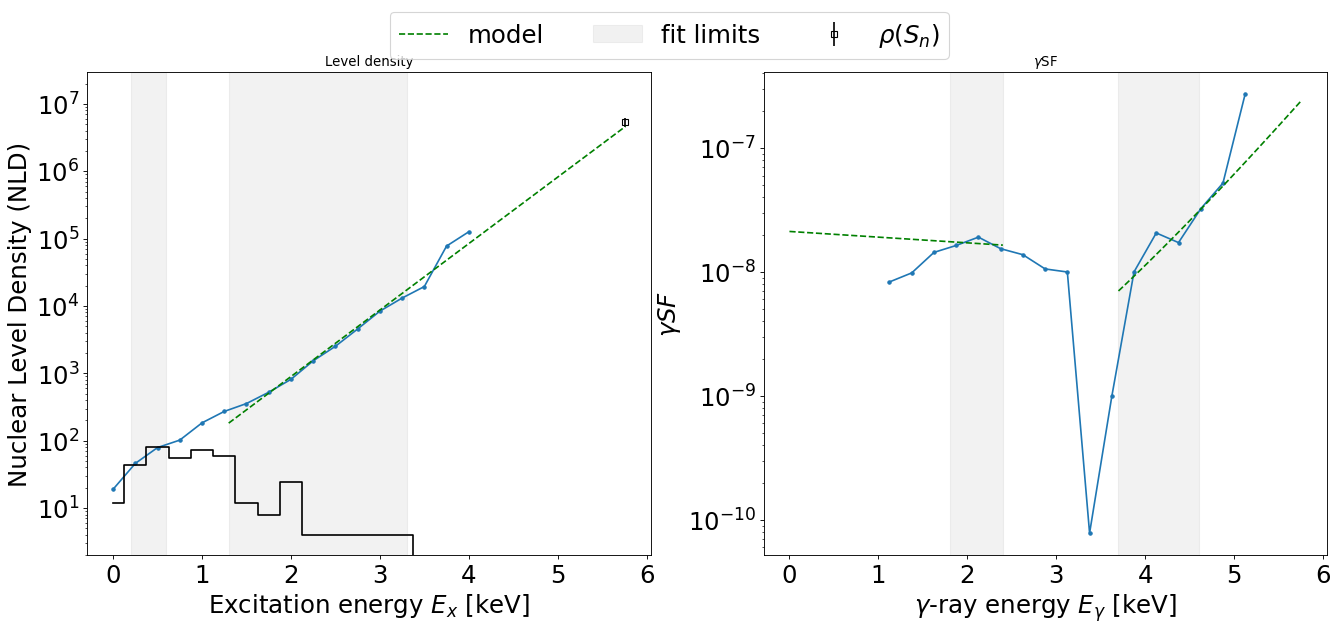

In [132]:
normlog = om.introspection.get_logger('normalizer_simultan', 'INFO')
simnorm = om.NormalizerSimultan(normalizer_nld=nldnorm, normalizer_gsf=gsfnorm, regenerate=regenerator)
simnorm.gsf = extractor.gsf[0]
simnorm.nld = extractor.nld[0]

# running faster than the default 400 given less precise answers
# For propper calc. you may rather increase this to > 400.
simnorm.multinest_kwargs["n_live_points"] = 10
simnorm.normalize()

#plot normalization
fig, ax = plt.subplots(1,2, figsize=(figwidth*2, figheigth))
simnorm.plot(ax=ax, add_figlegend=False);
fig.legend(loc=9, ncol=4, frameon=True, fontsize=label_fontsize)
ax[0].tick_params(axis='both', labelsize=tick_labelsize)
ax[1].tick_params(axis='both', labelsize=tick_labelsize)
ax[1].set_xlabel('$\gamma$-ray energy $E_\gamma$ [keV]',fontsize=label_fontsize)
ax[0].set_xlabel('Excitation energy $E_x$ [keV]',fontsize=label_fontsize)
ax[0].set_ylabel('Nuclear Level Density (NLD)',fontsize=label_fontsize)
ax[1].set_ylabel('$\gamma SF$',fontsize=label_fontsize)
fig.axes[1].tick_params(labelsize=tick_labelsize)
fig.savefig('normalized_nld_gsf', dpi=save_dpi)

In [103]:
normlog = om.introspection.get_logger('normalizer_emsemble_simultan', 'INFO')
ensemblenorm_sim = om.EnsembleNormalizer(extractor=extractor, normalizer_simultan=simnorm, regenerate=regenerator)

ensemblenorm_sim.normalize()

2020-09-28 17:25:33,636 - ompy.normalizer_nld - INFO - DE results:
┌──────────────────┬───────────┬────────────────────┬────────────────────┐
│ A                │ α [MeV⁻¹] │ T [MeV]            │ Eshift [MeV]       │
╞══════════════════╪═══════════╪════════════════════╪════════════════════╡
│ 8.08576310130603 │ 0.1       │ 0.8181892400828958 │ -2.172429589040977 │
└──────────────────┴───────────┴────────────────────┴────────────────────┘
2020-09-28 17:25:33,682 - ompy.normalizer_gsf - INFO - Normalizing #0
2020-09-28 17:25:33,689 - ompy.normalizer_simultan - INFO - DE results/initial guess:
┌──────────────────┬───────────┬────────────────────┬────────────────────┬───────────────────┐
│ A                │ α [MeV⁻¹] │ T [MeV]            │ Eshift [MeV]       │ B                 │
╞══════════════════╪═══════════╪════════════════════╪════════════════════╪═══════════════════╡
│ 8.08576310130603 │ 0.1       │ 0.8181892400828958 │ -2.172429589040977 │ 22.56204429479821 │
└──────────────────┴──

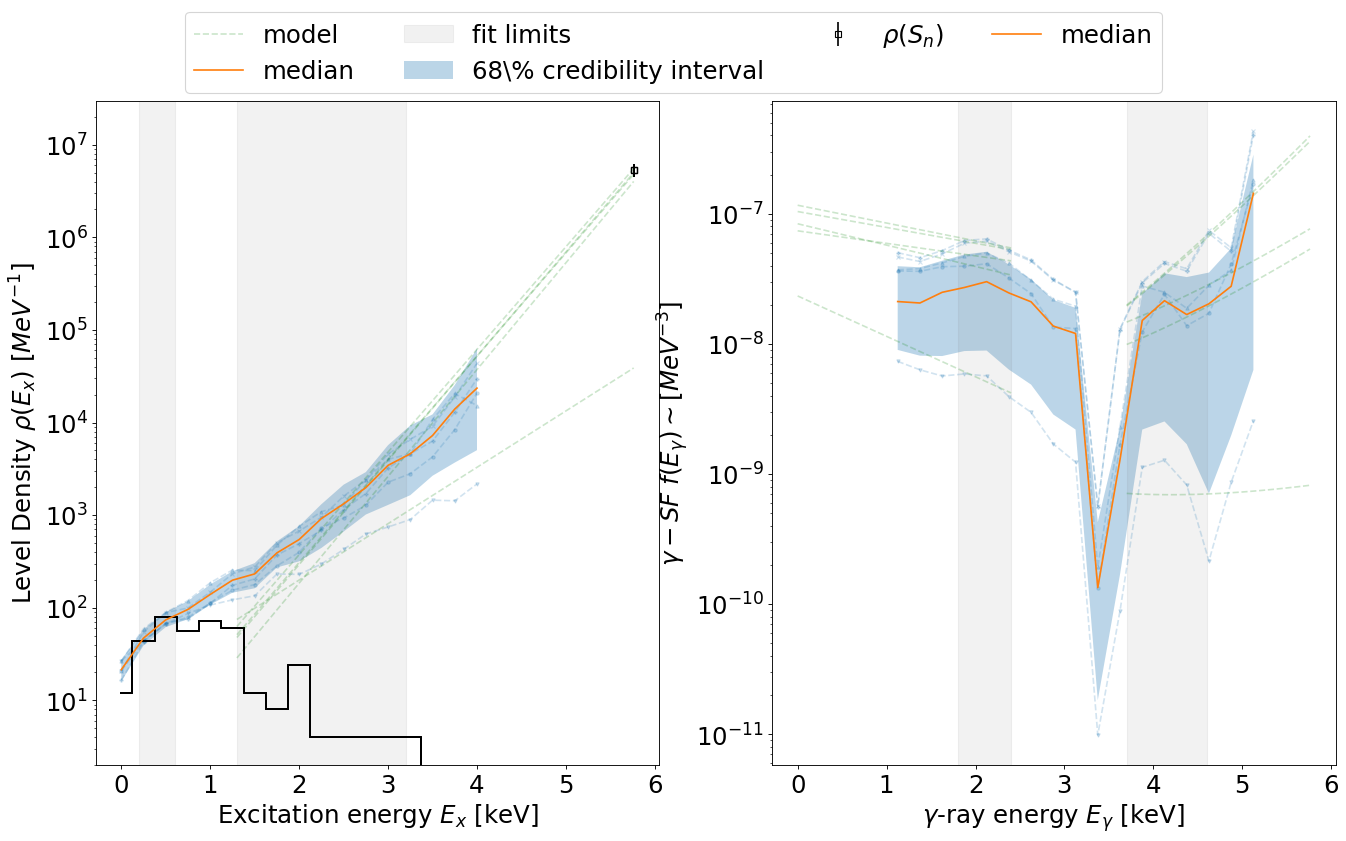

In [104]:
fig, ax = plt.subplots(1,2, figsize=(figwidth*2, figheigth+3))
ensemblenorm_sim.plot(ax=ax, n_plot=5, add_figlegend=False)#, random_state=np.random.default_rng(65546645));
fig.legend(loc=9, ncol=4, frameon=True, fontsize=label_fontsize)
ax[0].tick_params(axis='both', labelsize=tick_labelsize)
ax[1].tick_params(axis='both', labelsize=tick_labelsize)
ax[1].set_xlabel('$\gamma$-ray energy $E_\gamma$ [keV]',fontsize=label_fontsize)
ax[0].set_xlabel('Excitation energy $E_x$ [keV]',fontsize=label_fontsize)
ax[0].set_ylabel('Level Density $\\rho(E_x)$ $[MeV^{-1}]$',fontsize=label_fontsize)
ax[1].set_ylabel('$\gamma-SF$ $f(E_\gamma)\sim [MeV^{-3}]$',fontsize=label_fontsize)
fig.axes[1].tick_params(labelsize=tick_labelsize)